# Installing the MATLAB Engine for Python

To run MATLAB code directly from Python, you need to install the MATLAB Engine API.  
Follow these steps:

1. Navigate to the `extern/engines/python` folder inside your MATLAB installation directory:

   ```bash
   cd matlabroot/extern/engines/python
   ```

   (Replace `matlabroot` with the actual path to your MATLAB installation. You can find it by running `matlabroot` in the MATLAB Command Window.)

2. Activate the Python environment where you want to use MATLAB (if you are using a virtual environment).

3. Install the MATLAB engine package by running:

   ```bash
   python setup.py install
   ```

In [77]:
import matlab.engine

In [78]:
import os

base_path = os.getcwd()  # current working directory
matlab_path = os.path.join(base_path, 'matlab')
enums_path = os.path.join(base_path, 'matlab/enums')
parameters_path = os.path.join(base_path, 'matlab/parameters')

In [79]:
# Start MATLAB engine
eng = matlab.engine.start_matlab()

# Add relative paths to MATLAB engine
eng.addpath(matlab_path, nargout=0)
eng.addpath(enums_path, nargout=0)
eng.addpath(parameters_path, nargout=0)

In [80]:
eng.eval("""
    % Create the simulator object
    simulator = Factory.createSimulator(SimulatorMode.Infusion);
    
    k = 1;
    
    % Display the patient ID
    disp(['Patient id: ', num2str(k)]);
    
    % Set variables for the simulation
    interaction = Interaction.Surface;
    dohMeasure = DoHMeasure.Both;
    t_sim = 30*60;  % Simulation time in seconds
    t_s = 5;  % Time step in seconds

    % Define the PK and PD models using containers.Map
    pk_models = containers.Map({'prop', 'remi'}, {Model.Eleveld, Model.Eleveld});
    pd_models = containers.Map({'prop', 'remi'}, {Model.Eleveld, Model.Eleveld});
    
    % Initialize the containers.Map
    stimuli = containers.Map('KeyType', 'double', 'ValueType', 'any');
    
    % Add stimuli entries as structures
    stimuli(1*60)  = struct('disturbanceType', DisturbanceType.INTUBATION, 'duration', 2 * 60,  'deltas', [10, 10, 20]);
    stimuli(5*60)  = struct('disturbanceType', DisturbanceType.INCISION, 'duration', 2 * 60,  'deltas', [10, 10, 20]);
    stimuli(21*60) = struct('disturbanceType', DisturbanceType.SUTURE, 'duration', 2 * 60,  'deltas', [2, 2, 4]);

    % Define the var cell array with key-value pairs
    var = {'opiates', true, ...
           'blood_sampling', BloodSampling.ARTERIAL, ...
           'interaction', interaction, ...
           'doh_measure', dohMeasure, ...
           'pk_models', pk_models, ...
           'pd_models', pd_models, ...
           'stimuli', stimuli, ...
           'seed_disturbance', 42};

    % Initialize the simulation
    simulator.init_simulation_from_file(k, t_sim, t_s, var{:});

    % Define the drug infusion rates
    u_prop = ones(t_sim,1) * 0.2;
    u_remi = ones(t_sim,1) * 0.2;
    u_nore = ones(t_sim,1) * 0.01;
    u_rocu = ones(t_sim,1) * 0.1;

    % Run the simulation
    simulator.run_complete_simulation(u_prop, u_remi, u_nore, u_rocu);

    % Save the simulation results
    simulator.save_simulation();
""", nargout=0)

Patient id: 1
Patient has entered the maintenance phase


In [81]:
# Get the result from MATLAB
matlab_result = eng.eval("simulator.get_patient_results()", nargout=1)

maltab_disturbances = eng.eval("simulator.get_patient_disturbances()", nargout=1)

print("MATLAB result:", matlab_result)

MATLAB result: <matlab.object object at 0x1694f2630>


In [82]:
# Get the result and disturbances from MATLAB
matlab_result = eng.eval("simulator.get_patient_results()", nargout=1)
matlab_disturbances = eng.eval("simulator.get_patient_disturbances()", nargout=1)

# Extract the keys and values from the containers.Map for results
result_keys = eng.eval("keys(simulator.get_patient_results())", nargout=1)
result_values = eng.eval("values(simulator.get_patient_results())", nargout=1)

# Convert keys and values into Python lists
py_result_keys = list(result_keys)
py_result_values = list(result_values)

# Flatten the result values
for i in range(len(py_result_values)):
    py_result_values[i] = [item[0] for item in py_result_values[i]]

# Create a Python dictionary for results
matlab_result = dict(zip(py_result_keys, py_result_values))

# Repeat for disturbances

# Extract keys and values from the containers.Map for disturbances
dist_keys = eng.eval("keys(simulator.get_patient_disturbances())", nargout=1)
dist_values = eng.eval("values(simulator.get_patient_disturbances())", nargout=1)

# Convert keys and values into Python lists
py_dist_keys = list(dist_keys)
py_dist_values = list(dist_values)

# Flatten the disturbance values
for i in range(len(py_dist_values)):
    py_dist_values[i] = [float(item[0]) for item in py_dist_values[i]]

# Create a Python dictionary for disturbances
matlab_disturbances = dict(zip(py_dist_keys, py_dist_values))

# print("MATLAB Results:", matlab_result)
# print("MATLAB Disturbances:", matlab_disturbances)

In [83]:
# Quit MATLAB engine
eng.quit()

In [84]:
# External library import
!pip install control

# Local libraries import
from python.AReS import Simulator, Model, Interaction, DoHMeasure, DisturbanceType, SimulatorMode

import matplotlib.pyplot as plt
import numpy as np

In [85]:
simulator = Simulator.create(SimulatorMode.INFUSION)

k = 0

interaction = Interaction.SURFACE
dohMeasure = DoHMeasure.BOTH
t_sim = 30*60
t_s = 5
pk_models = {'prop': Model.ELEVELD, 'remi': Model.ELEVELD}
pd_models = {'prop': Model.ELEVELD, 'remi': Model.ELEVELD}

stimuli = {
    1 * 60: (DisturbanceType.INTUBATION, 2 * 60, [10, 10, 20]), 
    5 * 60: (DisturbanceType.INCISION, 2 * 60, [10, 10, 20]),
    21 * 60: (DisturbanceType.SUTURE, 2 * 60, [2, 2, 4])
}

simulator.init_simulation_from_file(id_patient=k, t_sim=t_sim, t_s=t_s, pk_models=pk_models,
                                    pd_models=pd_models, interaction=interaction, doh_measure=dohMeasure,
                                    stimuli=stimuli, seed_disturbance=42)

u_prop = [0.2] * t_sim
u_remi = [0.2] * t_sim
u_nore = [0.01] * t_sim
u_rocu = [0.1] * t_sim
simulator.run_complete_simulation(u_prop, u_remi, u_nore, u_rocu)
simulator.save_simulation()

# Get the result from Python
py_results = simulator.get_patient_results()

py_disturbances = simulator.get_patient_disturbances()

# print("Python result:", py_results)
# print("Python disturbances:", py_disturbances)

In [86]:
py_results = {key.replace('_', '', 1).lower(): value for key, value in py_results.items()}

In [87]:
# Compare the keys
if matlab_result.keys() == py_results.keys():
    print("The keys are the same.")
else:
    print("The keys are different.")
    print("MATLAB keys:", matlab_result.keys())
    print("Python keys:", py_results.keys())

The keys are the same.


In [88]:
if matlab_disturbances.keys() == py_disturbances.keys():
    print("The keys are the same.")
else:
    print("The keys are different.")
    print("MATLAB keys:", matlab_disturbances.keys())
    print("Python keys:", py_disturbances.keys())

The keys are the same.


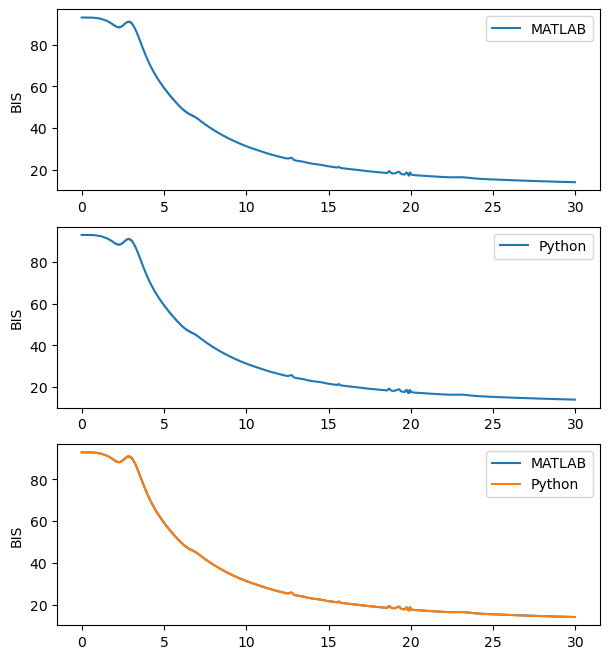

<Figure size 640x480 with 0 Axes>

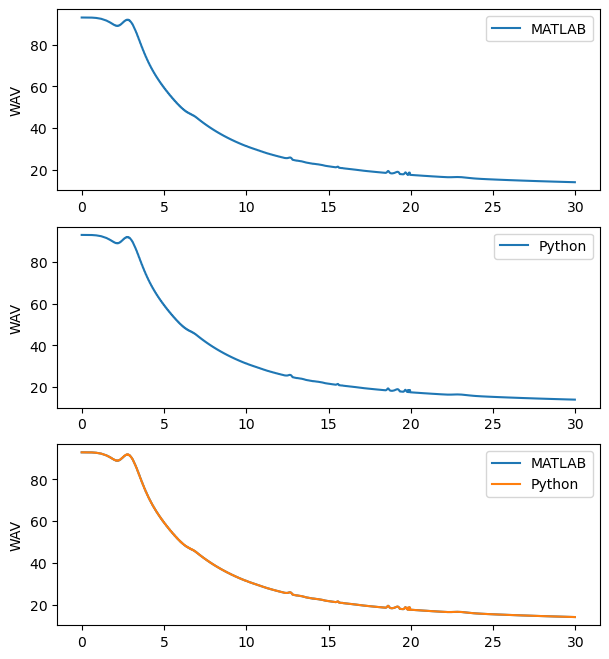

<Figure size 640x480 with 0 Axes>

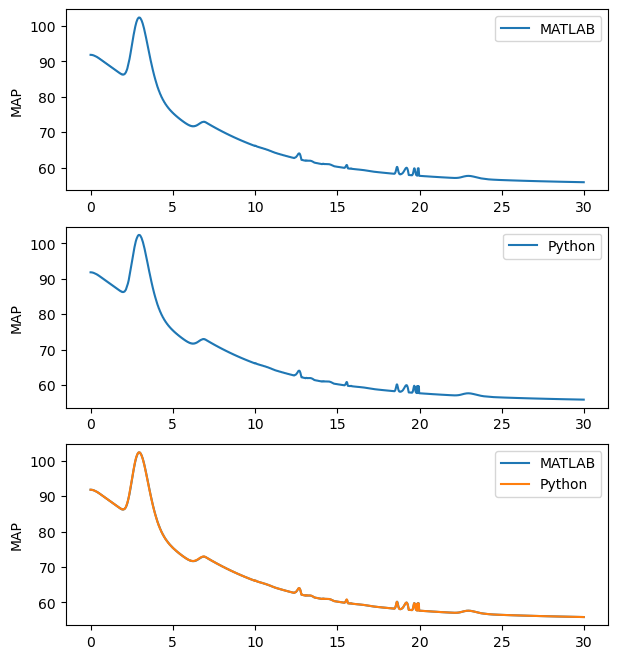

<Figure size 640x480 with 0 Axes>

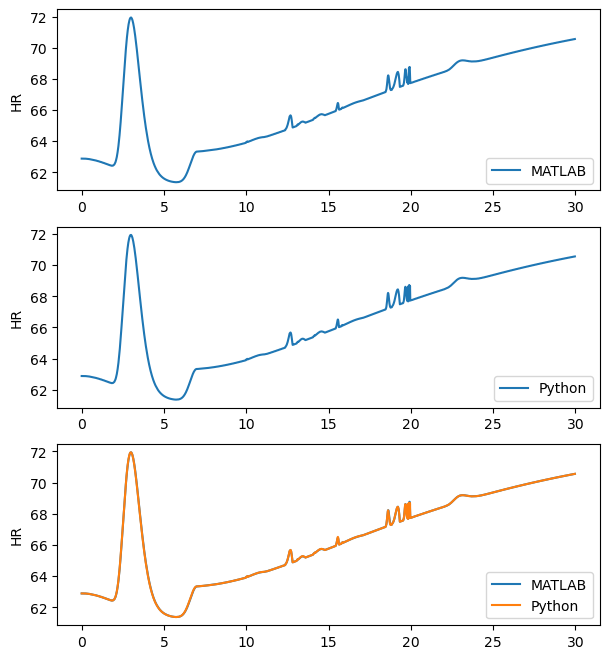

<Figure size 640x480 with 0 Axes>

In [89]:
names = {'bis_all': 'BIS','wav_all':'WAV', 'map_all': 'MAP', 'hr_all': 'HR'}

num_samples = len(matlab_result['bis_all'])
t_sim = np.arange(num_samples-1) / 60

for key in ['bis_all','wav_all', 'map_all', 'hr_all']:
    fig, ax = plt.subplots(3, 1, figsize=(7, 8))

    ax[0].plot(t_sim,matlab_result[key][:-1],label='MATLAB')
    ax[0].set_ylabel(names[key])
    ax[0].legend()

    ax[1].plot(t_sim,py_results[key][0][:-1], label='Python')
    ax[1].set_ylabel(names[key])
    ax[1].legend()

    ax[2].plot(t_sim,matlab_result[key][:-1], label='MATLAB')
    ax[2].plot(t_sim,py_results[key][0][:-1], label='Python')
    ax[2].set_ylabel(names[key])
    ax[2].legend()

    plt.show()
    plt.clf()

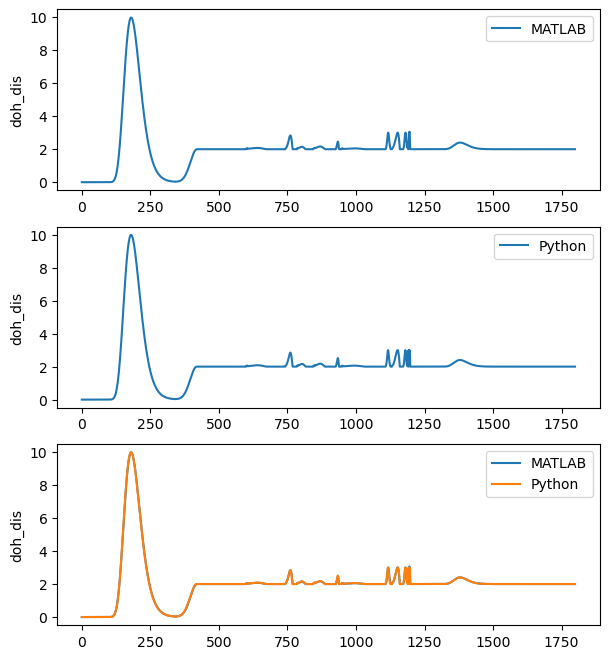

<Figure size 640x480 with 0 Axes>

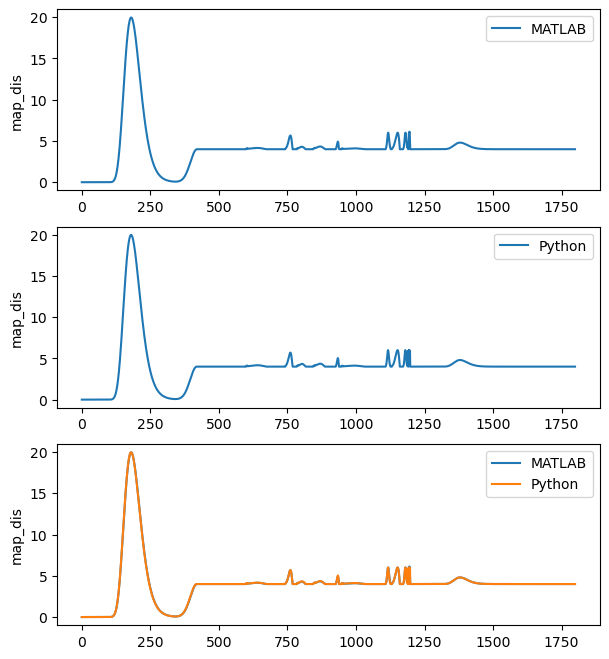

<Figure size 640x480 with 0 Axes>

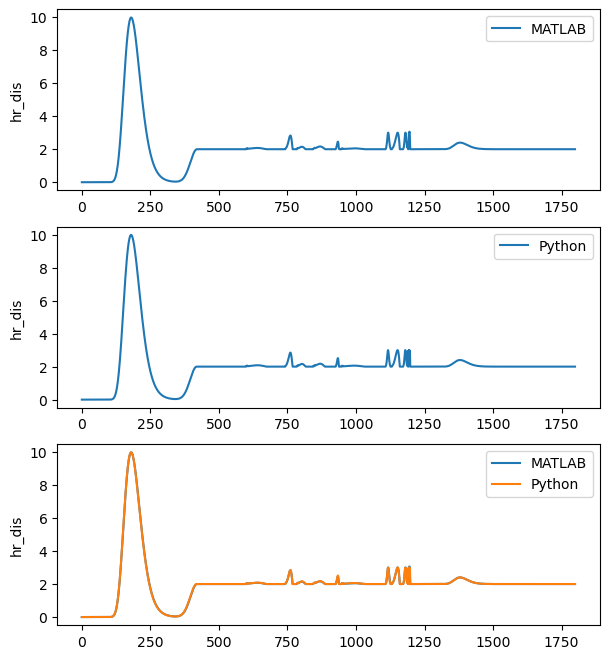

<Figure size 640x480 with 0 Axes>

In [90]:
t_sim = np.arange(len(matlab_disturbances['doh_dis']))

for key in ['doh_dis', 'map_dis', 'hr_dis']:
    fig, ax = plt.subplots(3, 1, figsize=(7, 8)) 

    ax[0].plot(t_sim,matlab_disturbances[key], label='MATLAB')
    ax[0].set_ylabel(key)
    ax[0].legend()

    ax[1].plot(t_sim,py_disturbances[key], label='Python')
    ax[1].set_ylabel(key)
    ax[1].legend()

    ax[2].plot(t_sim,matlab_disturbances[key], label='MATLAB')
    ax[2].plot(t_sim,py_disturbances[key], label='Python')
    ax[2].set_ylabel(key)
    ax[2].legend()

    plt.show()
    plt.clf()

In [91]:
import numpy as np

# Set a threshold value
threshold = 0.3

def compare_dicts_with_threshold(dict1, dict2, threshold):
    for key in dict1:
        print("Examining key:", key)
        arr1 = np.array(dict1[key])
        arr2 = np.array(dict2[key])
        print("\n")

        diff = np.isclose(arr1, arr2[0], atol=threshold)

        if not np.all(diff):
            print("Arrays differ at the following indices:")
            differing_indices = np.where(~diff)[0]
            for idx in differing_indices:
                print(f"Idx {idx} - Min {idx/60:.0f}: arr1 = {arr1[idx]}, arr2 = {arr2[0][idx]}")
            print("Arrays are not equal within the threshold.\n")


In [92]:
compare_dicts_with_threshold(matlab_result, py_results, threshold)

Examining key: bis_all


Arrays differ at the following indices:
Idx 1189 - Min 20: arr1 = 17.770645624815266, arr2 = 17.309029739959524
Idx 1194 - Min 20: arr1 = 17.578163833192235, arr2 = 18.23601860477855
Idx 1195 - Min 20: arr1 = 17.86170442973745, arr2 = 17.407887014450985
Idx 1197 - Min 20: arr1 = 18.67880575369702, arr2 = 17.549054989954953
Arrays are not equal within the threshold.

Examining key: c_nore_all


Examining key: ce_bis_all


Examining key: ce_del_all


Examining key: ce_prop_all


Examining key: ce_remi_all


Examining key: ce_rocu_all


Examining key: ce_wav_all


Examining key: co_all


Examining key: cp_prop_all


Examining key: cp_remi_all


Examining key: cp_rocu_all


Examining key: hr_all


Arrays differ at the following indices:
Idx 1189 - Min 20: arr1 = 68.06992506195873, arr2 = 68.61209170008354
Idx 1194 - Min 20: arr1 = 68.70502057424146, arr2 = 67.74895750776042
Idx 1196 - Min 20: arr1 = 68.75662905159669, arr2 = 67.77486864189068
Idx 1197 - Min 20: arr

In [93]:
threshold = 0.3

def compare_dicts_with_threshold(dict1, dict2, threshold):
    for key in dict1:
        print("Examining key:", key)
        arr1 = np.array(dict1[key])
        arr2 = np.array(dict2[key])
        print("\n")

        diff = np.isclose(arr1, arr2, atol=threshold)

        if not np.all(diff):
            print("Arrays differ at the following indices:")
            differing_indices = np.where(~diff)[0]
            for idx in differing_indices:
                print(f"Idx {idx}  -Min {idx/60:.0f}: arr1 = {arr1[idx]}, arr2 = {arr2[idx]}")
            print("Arrays are not equal within the threshold.\n")


In [94]:
compare_dicts_with_threshold(matlab_disturbances, py_disturbances, threshold)

Examining key: doh_dis


Arrays differ at the following indices:
Idx 1189  -Min 20: arr1 = 2.3955619103305517, arr2 = 2.93772854853938
Idx 1194  -Min 20: arr1 = 2.9999050451109595, arr2 = 2.043841978714677
Idx 1196  -Min 20: arr1 = 3.0438419677441035, arr2 = 2.062081558123069
Idx 1197  -Min 20: arr1 = 2.3955618663745852, arr2 = 2.937728504583201
Arrays are not equal within the threshold.

Examining key: hr_dis


Arrays differ at the following indices:
Idx 1189  -Min 20: arr1 = 2.3955619103305517, arr2 = 2.93772854853938
Idx 1194  -Min 20: arr1 = 2.9999050451109595, arr2 = 2.043841978714677
Idx 1196  -Min 20: arr1 = 3.0438419677441035, arr2 = 2.062081558123069
Idx 1197  -Min 20: arr1 = 2.3955618663745852, arr2 = 2.937728504583201
Arrays are not equal within the threshold.

Examining key: map_dis


Arrays differ at the following indices:
Idx 1183  -Min 20: arr1 = 5.432872832216934, arr2 = 5.126368912033867
Idx 1184  -Min 20: arr1 = 5.026644438151587, arr2 = 4.720705777243197
Idx 1189  -M